In [50]:
import random

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import openpyxl
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow


In [26]:
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [27]:
# Path for Tess dataset
tess = "datasets/TESS"

In [28]:
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(tess + "/" + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(tess + "/" + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
print(Tess_df.shape)
Tess_df.head()


(2800, 2)


,Emotions,Path
0,angry,datasets/TESS/OAF_angry/OAF_back_angry.wav
1,angry,datasets/TESS/OAF_angry/OAF_bar_angry.wav
2,angry,datasets/TESS/OAF_angry/OAF_base_angry.wav
3,angry,datasets/TESS/OAF_angry/OAF_bath_angry.wav
4,angry,datasets/TESS/OAF_angry/OAF_bean_angry.wav


In [29]:
data_path = pd.concat([Tess_df], axis=0)
data_path.to_csv("data_path_T.csv", index=False)
data_path.head()

,Emotions,Path
0,angry,datasets/TESS/OAF_angry/OAF_back_angry.wav
1,angry,datasets/TESS/OAF_angry/OAF_bar_angry.wav
2,angry,datasets/TESS/OAF_angry/OAF_base_angry.wav
3,angry,datasets/TESS/OAF_angry/OAF_bath_angry.wav
4,angry,datasets/TESS/OAF_angry/OAF_bean_angry.wav


In [30]:
emotionList = pd.read_csv("data_path_T.csv")
emotions = emotionList["Emotions"]
emotionCount = {}
for item in emotions:
    if item in emotionCount:
        emotionCount[item] += 1
    else:
        emotionCount[item] = 1
emotionCount=dict(sorted(emotionCount.items(), key=lambda x:x[0]))
print(emotionCount)

{'angry': 400, 'disgust': 400, 'fear': 400, 'happy': 400, 'neutral': 400, 'sad': 400, 'surprise': 400}


['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

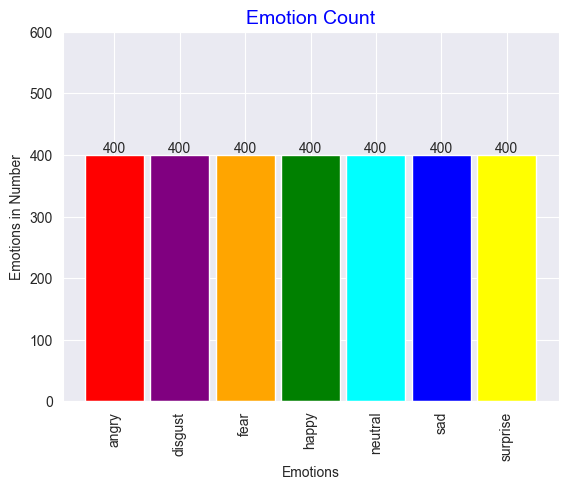

In [31]:
plt.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt.xlabel("Emotions")
plt.xticks(rotation=90)
plt.ylabel("Emotions in Number")
plt.title("Emotion Count", size=14, color="Blue")
plt.ylim([0, max(emotionCount.values()) + 200])
lst = []
for item in emotionCount:
    plt.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")
sorted(emotionCount)

# emotionCount.values()

# for index, value in enumerate(emotionCount)
# for index,value in enumerate(emotionCount.values()):
#     plt.text(value,index,value)
# plt.show()


In [32]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


In [33]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def volumeAdd(data):
    songData = AudioSegment.from_wav(data)
    print("sing", songData)
    songDataSamples = np.array(songData.get_array_of_samples())
    songHighVolumed = songDataSamples - 10000.0
    print(songHighVolumed)
    return songHighVolumed


datasets/TESS/OAF_angry/OAF_bar_angry.wav


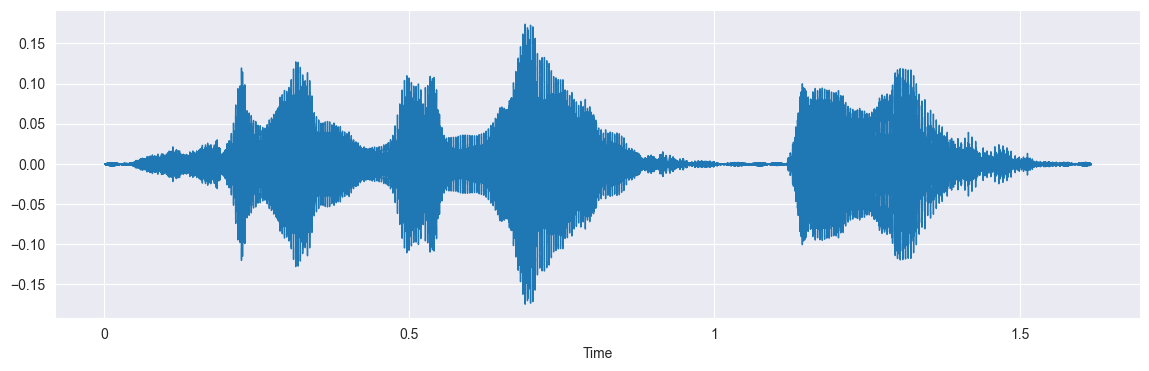

In [34]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
print(path)
data, sample_rate = librosa.load(path)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)


In [35]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2))  # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result


In [36]:
# X, Y = [], []
# for path, emotion in zip(data_path.Path, data_path.Emotions):
#     try:
#         feature = get_features(path)
#     except:
#         print(path)
#         print(emotion)
#     for ele in feature:
#         try:
#             X.append(ele)
#             # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
#             Y.append(emotion)
#         except:
#             print(ele)

In [37]:
# len(X), len(Y), data_path.Path.shape

In [38]:
# Features = pd.DataFrame(X)
# Features['labels'] = Y
# Features.to_excel('features_T.xlsx', index=False)
# Features.head()


In [39]:
features_df = pd.read_excel("features_T.xlsx")

In [40]:
featuresofit = np.asarray(features_df.iloc[:,:-1].values)
X = featuresofit
labelofit = np.asarray(features_df['labels'])
Y = labelofit

In [64]:
emotionsfromFeatures = features_df['labels']
emotionCountfromFeatures = {}
for item in emotionsfromFeatures:
    if item in emotionCountfromFeatures:
        emotionCountfromFeatures[item] += 1
    else:
        emotionCountfromFeatures[item] = 1
print(emotionCountfromFeatures)

{'angry': 1200, 'disgust': 1200, 'fear': 1200, 'happy': 1200, 'neutral': 1200, 'surprise': 1200, 'sad': 1200}


In [42]:
# X = Features.iloc[:, :-1].values
# Y = Features['labels'].values

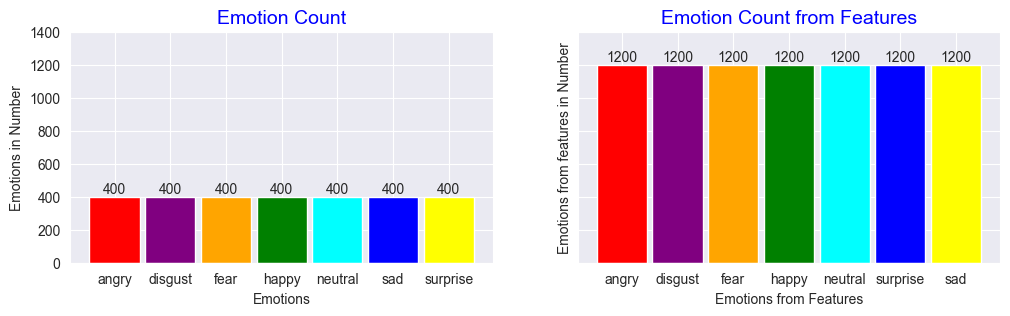

In [65]:
fig, (plt1,plt2) = plt.subplots(1,2,sharey=True, figsize=(12,3))
plt1.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt1.set_xlabel("Emotions")
plt1.set_ylabel("Emotions in Number")
plt1.set_title("Emotion Count", size=14, color="Blue")
plt1.set_ylim([0, max(emotionCount.values()) + 200])
# lst = []
for item in emotionCount:
    plt1.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")

plt2.bar(emotionCountfromFeatures.keys(), emotionCountfromFeatures.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt2.set_xlabel("Emotions from Features")
plt2.set_ylabel("Emotions from features in Number")
plt2.set_title("Emotion Count from Features", size=14, color="Blue")
plt2.set_ylim([0, max(emotionCountfromFeatures.values()) + 200])
# lst = []
for item in emotionCountfromFeatures:
    plt2.text(item, emotionCountfromFeatures[item],
             emotionCountfromFeatures[item], ha="center", va="bottom")
# plt2.subplots(nrows=1,ncols=2)

In [72]:
# print(Y)
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=0, test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# pd.DataFrame(Y)

((6720, 162), (6720,), (1680, 162), (1680,))

In [76]:
scaler = StandardScaler()
# scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6720, 162), (6720,), (1680, 162), (1680,))

In [77]:
# kernelchoice = ["rbf"]
kernelchoice = ["linear"]
C_choice = [100, 150, 200, 250, 300]
# C_choice = [0.5, 0.6, 0.8, 0.9, 1]
import random

In [78]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

for i in C_choice:
    a=random.choice(kernelchoice)
    b=random.choice(C_choice)
    classifier = svm.SVC(kernel='linear', gamma="auto", C=b)
    classifier = OneVsRestClassifier(classifier)
    classifier.fit(x_train, y_train)
    y_predict = classifier.predict(x_test)
    accuracyPercent = accuracy_score(y_test, y_predict) * 100
    print("Kernel:  "+ str(a) + "  ||  "+" C: " + str(b) +"  ||  Accuracy"+ "  :  " + str(accuracyPercent))

Kernel:  linear  ||   C: 200  ||  Accuracy  :  95.83333333333334
Kernel:  linear  ||   C: 100  ||  Accuracy  :  95.95238095238095
Kernel:  linear  ||   C: 100  ||  Accuracy  :  95.95238095238095
Kernel:  linear  ||   C: 300  ||  Accuracy  :  95.83333333333334
Kernel:  linear  ||   C: 300  ||  Accuracy  :  95.83333333333334


Robust Scalar
Kernel:  linear  ||   C: 0.8  ||  Accuracy  :  96.30952380952381
Kernel:  linear  ||   C: 0.5  ||  Accuracy  :  96.25
Kernel:  linear  ||   C: 0.5  ||  Accuracy  :  96.25
Kernel:  linear  ||   C: 0.5  ||  Accuracy  :  96.25
Kernel:  linear  ||   C: 0.9  ||  Accuracy  :  96.13095238095238
Kernel:  rbf  ||   C: 0.6  ||  Accuracy  :  96.42857142857143
Kernel:  rbf  ||   C: 1  ||  Accuracy  :  96.13095238095238
Kernel:  rbf  ||   C: 0.8  ||  Accuracy  :  96.30952380952381
Kernel:  rbf  ||   C: 0.9  ||  Accuracy  :  96.13095238095238
Kernel:  rbf  ||   C: 0.6  ||  Accuracy  :  96.4285714285714

Standard Scalar
Kernel:  linear  ||   C: 0.6  ||  Accuracy  :  96.36904761904762
Kernel:  linear  ||   C: 0.5  ||  Accuracy  :  96.54761904761905
Kernel:  linear  ||   C: 0.6  ||  Accuracy  :  96.36904761904762
Kernel:  linear  ||   C: 0.8  ||  Accuracy  :  96.48809523809524
Kernel:  linear  ||   C: 0.8  ||  Accuracy  :  96.48809523809524




In [48]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       angry       0.97      0.99      0.98       256
     disgust       0.97      0.97      0.97       230
        fear       1.00      1.00      1.00       237
       happy       0.97      0.94      0.96       247
     neutral       1.00      0.99      1.00       268
         sad       0.98      0.99      0.99       219
    surprise       0.94      0.95      0.94       223

    accuracy                           0.98      1680
   macro avg       0.98      0.98      0.98      1680
weighted avg       0.98      0.98      0.98      1680

              precision    recall  f1-score   support

       angry       0.97      0.98      0.98       256
     disgust       0.97      0.97      0.97       230
        fear       1.00      1.00      1.00       237
       happy       0.97      0.96      0.96       247
     neutral       1.00      0.99      1.00       268
         sad       0.99      0.99      0.99       219
    surprise       0.95 